<a href="https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/master/pathomics/lung_cancer_cptac_TissueClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDC Tutorial: Tissue classification in slide microscopy images

This notebook demonstrates how to use the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non-small cell lung cancer histopathology images using deep learning" ([Coudray et al., 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into normal, adenocarcinoma (LUAD), and squamous cell carcinoma (LSCC) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be run in Google Colab. The total runtime of the notebook is about **75 minutes**. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. For more complex use cases it is strongly recommended to use GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!

## Prerequisites

Before we begin, some prerequisites have to be fulfilled and some individual adjustments must be made as described in this section:

**Enable GPU:** This notebook is intended to be run using a GPU. In Google Colab, GPU usage can be enabled via Edit > Notebooks Settings > Hardware accelerator. Since Collab notebooks are assigned arbitrary GPUs (eg., NVIDIA K80, T4, P4 and P100), processing times can vary.  During the first steps of the notebook (which do not utilize the GPU) Colab might ask if you want to switch back to a CPU. If so, please deny that by closing the notification. The code below checks whether GPU usage has been enabled and which GPU type the Colab instance is equipped with.

In [ ]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

**Authenticate:** To access IDC resources, you have to authenticate with your Google identity. Follow the link generated by the code below and enter the displayed verification code to complete the Google authentication process.

In [ ]:
from google.colab import auth
auth.authenticate_user()

**Create a Google Cloud Platform project:** In order to crossload whole slide images from IDC storage into the Colab VM you will need to have a Google Cloud Platform project with billing enabled. You can learn how to create your own project [here](https://www.youtube.com/watch?v=i08S0KJLnyw). You are also encouraged to apply for free cloud credits from IDC by submitting the application form referenced [here](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits). Once you have the google project with billing enabled, set `my_project_id` below to the ID of your GCP project.

In [2]:
my_project_id = 'idc-pathomics-000'

## Environment setup

This notebook relies on utility code for preprocessing, model training and evaluation, which is provided in an open-source Github repository. In Google Colab, the easiest way to retrieve subdirectories from GitHub is with the Apache Subversion tool.

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y subversion

In [ ]:
!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/trunk/pathomics/idc_pathomics/

Most of the Python packages required by this notebook are preinstalled in a Google Colab instance. In addition, we need to install [wsidicom](https://pypi.org/project/wsidicom/) for accessing whole-slide images.

In [ ]:
%%capture 
!sudo pip3 install wsidicom==0.2.0

Import the required Python modules.

In [4]:
import os
import sys
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # Hide Python warnings to improve readability.
    warnings.simplefilter('ignore')

Determine who and where we are.

In [ ]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -rf sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Create directories for input and output data.

In [1]:
input_dir = os.path.join(curr_dir[-1], 'idc_input')
output_dir = os.path.join(curr_dir[-1], 'idc_output')

if not os.path.exists(input_dir):
    os.makedirs(input_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

NameError: name 'os' is not defined

## Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they can be retrieved on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the *idc-open* bucket.

Metadata for the DICOM files — including standard DICOM tags, but also non-DICOM metadata — are stored in the BigQuery table *canceridc-data.idc_current.dicom_all*. The IDC Documentation gives further information on [data organization](https://learn.canceridc.dev/data/organization-of-data) and [code examples](https://learn.canceridc.dev/cookbook/bigquery) on how to query the table. The easiest way to access BigQuery tables from a Jupyter notebook is to use [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) with the `%%bigquery` command. 

The following statement loads relevant metadata of all slide images from the CPTAC-LUAD and CPTAC-LSCC datasets into a pandas data frame called `slides_df`.

In [5]:
%%bigquery slides_df --project=$my_project_id 

SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS dataset,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    StudyInstanceUID AS idc_viewer_id,        
    gcs_url, -- URL of the Google Cloud storage bucket
    CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
          PixelMeasuresSequence[OFFSET(0)].
          PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    -- rename TransferSyntaxUIDs for readability
    CASE TransferSyntaxUID
        WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
        WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
        ELSE 'other'
    END AS compression
FROM canceridc-data.idc_current.dicom_all
WHERE
  NOT (ContainerIdentifier IS NULL)
  AND (ClinicalTrialProtocolID = "CPTAC-LUAD" OR ClinicalTrialProtocolID = "CPTAC-LSCC")

Downloading: 100%|██████████| 11800/11800 [00:01<00:00, 8666.76rows/s]


We reduce the obtained data frame to the images we actually want to use for the analysis. Those are required to be digitized at 5x magnification (corresponding to a pixel spacing between 0.0019 and 0.0021 mm) and compressed in JPEG format (to be readable by the OpenSlide libray). Also, we consider only every 10th slide to make the dataset small enough to be manageable in Google Colab.

In [6]:
slides_df.query('pixel_spacing > 0.0019 & pixel_spacing < 0.0021 & compression=="jpeg"', inplace=True)
slides_df = slides_df.sort_values(by='dataset').iloc[::10] # select every 10th row, ensure to keep original ratio of the two datasets LUAD and LSCC

The tissue type of the slides (tumor or normal) is not yet included in the *canceridc-data.idc_current.dicom_all* table. This information has to be supplemented from a separate CSV file provided by the TCIA. The cancer subtype (LSCC or LUAD) can in principle be inferred from the dataset name, but for clarity we also use the information in the CSV file.

In [7]:
type_df = pd.read_csv('idc_pathomics/tissue_type_data_TCIA.csv')[['Slide_ID', 'Specimen_Type', 'Tumor']]
# Harmonize column names and labels
type_df.rename(columns={'Slide_ID': 'slide_id', 'Specimen_Type': 'tissue_type', 'Tumor': 'cancer_subtype'}, inplace=True)
type_df.replace({'tissue_type': {'normal_tissue': 'normal', 'tumor_tissue': 'tumor'}}, inplace=True)
type_df.replace({'cancer_subtype': {'LSCC': 'lscc', 'LUAD': 'luad'}}, inplace=True)
slides_df = pd.merge(slides_df, type_df, how='inner', on='slide_id', sort=True)

With standard [pandas](https://pandas.pydata.org/) functionality, we can easily validate and summarize the compiled metadata.

In [8]:
# Assert uniqueness of slide_id values
assert(slides_df.slide_id.is_unique)

# Assert validity of class labels
assert set(slides_df.tissue_type.unique()) == set(['normal', 'tumor'])
assert set(slides_df.cancer_subtype.unique()) == set(['luad', 'lscc'])

display(slides_df.head())
print('Total number of slides: ', len(slides_df))
nr_slides = slides_df.groupby('cancer_subtype').size()
nr_patients = slides_df.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression,tissue_type,cancer_subtype
0,C3L-00094-21,C3L-00094,CPTAC-LUAD,5975,6492,2.25.256483820513498247834350500764146046385,gs://public-datasets-idc/2679f26e-6ba3-47cd-9c...,0.001977,jpeg,tumor,luad
1,C3L-00263-22,C3L-00263,CPTAC-LUAD,7967,5757,2.25.125137779423237512551896159433973181174,gs://public-datasets-idc/18898bd3-d967-4407-89...,0.001977,jpeg,tumor,luad
2,C3L-00263-25,C3L-00263,CPTAC-LUAD,6971,7604,2.25.125137779423237512551896159433973181174,gs://public-datasets-idc/a6271cd5-9d08-496c-a9...,0.001977,jpeg,tumor,luad
3,C3L-00279-24,C3L-00279,CPTAC-LUAD,6971,7502,2.25.274005329949220063545764627488183242393,gs://public-datasets-idc/d9850235-14ba-4fcc-ac...,0.001977,jpeg,normal,luad
4,C3L-00415-21,C3L-00415,CPTAC-LSCC,8963,6394,2.25.241555540397300020450502832982402101080,gs://idc-open-idc1/a061cb8a-f3bf-45cf-a76d-19a...,0.001977,jpeg,tumor,lscc


Total number of slides:  216
--> 107 slides from 100 LUAD patients
--> 109 slides from 103 LSCC patients


Using standard [matplotlib](https://matplotlib.org/) functionality, we can easily visualize some aspects of interest. The following code produces two histograms. The left graph shows the frequencies of numbers of slides per patient, while the right graph shows the proportions of slides derived from healthy or tumor tissue.

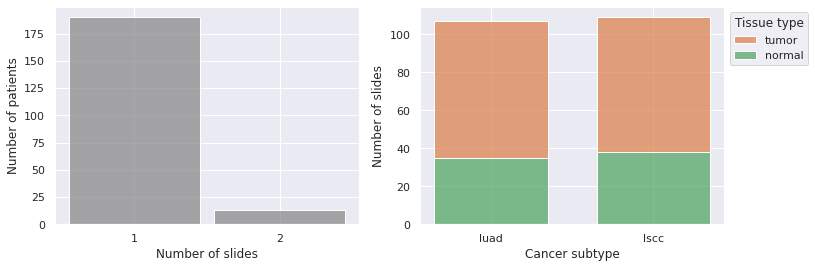

In [9]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Number of slides per patient 
slides_per_patient = slides_df.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})
ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # Force integer labels on x-axis

# Distribution of tissue types
plot2 = sns.histplot(data=slides_df, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C1', 'C2'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be viewed and explored in detail using the IDC viewer.

In [10]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[0]))
print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[100]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.256483820513498247834350500764146046385
https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.215805400598350703891771853155690470938


Finally, we save the information as CSV file *slides_metadata.csv* to be used later for splitting into training, validation and test sets.

In [13]:
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_df.to_csv(slides_metadata_path, index=False)

## Pathomics experiment

The following pathomics experiment aims to learn a classification model to realiably distinguish between healthy tissue, LUAD and LSCC tissue and consists of three main steps:

1. **Preprocessing**: Downloading slides from IDC storage buckets, extracting tiles and separating them into training, validation and test set
2. **Training**: Per-tile training of the machine-learning model
3. **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

The [`generate_tiles`](./idc_pathomics/data/tile_generation_cptac.py) function below iterates over the slides in *slides_metadata.csv*, downloads the respective WSI files and divides each WSI into non-overlapping tiles using wsidicom. The actual download is performed with the [gsutil tool](https://cloud.google.com/storage/docs/gsutil). Tiles are extracted at 5x magnification with a size of 128x128 pixels each. For each slide ID, a separate subfolder is created under the *cptac_tiles* directory where the respective tiles are stored. To shorten the runtime, only every fifth tile is considered. Nevertheless, this process still typically **takes between 20 and 30 minutes**.

In [25]:
from idc_pathomics.data.tile_generation import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides') 
tiles_dir = os.path.join(input_dir, 'cptac_tiles') 

generate_tiles(slides_dir, slides_metadata_path, tiles_dir, every_xth_tile=5, google_cloud_project_id=my_project_id)

1/216
Slide C3L-00094-21 already downloaded and tiled
2/216


Copying gs://public-datasets-idc/18898bd3-d967-4407-8991-e58a4c5854d1.dcm...
/ [1 files][ 10.0 MiB/ 10.0 MiB]                                                
Operation completed over 1 objects/10.0 MiB.                                     


Processing slide C3L-00263-22 - 2022-04-04 12:54:34.515989
3/216
Slide C3L-00263-25 already downloaded and tiled
4/216
Slide C3L-00279-24 already downloaded and tiled
5/216
Slide C3L-00415-21 already downloaded and tiled
6/216
Slide C3L-00422-25 already downloaded and tiled
7/216
Slide C3L-00444-28 already downloaded and tiled
8/216
Slide C3L-00503-23 already downloaded and tiled
9/216
Slide C3L-00510-23 already downloaded and tiled
10/216
Slide C3L-00603-22 already downloaded and tiled
11/216
Slide C3L-00893-25 already downloaded and tiled
12/216
Slide C3L-00965-22 already downloaded and tiled
13/216
Slide C3L-00973-27 already downloaded and tiled
14/216
Slide C3L-01000-25 already downloaded and tiled
15/216
Slide C3L-01330-23 already downloaded and tiled
16/216
Slide C3L-01455-26 already downloaded and tiled
17/216
Slide C3L-01663-26 already downloaded and tiled
18/216
Slide C3L-01683-27 already downloaded and tiled
19/216
Slide C3L-02127-25 already downloaded and tiled
20/216
Slide 

Copying gs://public-datasets-idc/801f65e4-f82f-4abd-809b-05031b3cff0f.dcm...


Processing slide C3N-00550-21 - 2022-04-04 12:54:36.415030
Some processing error for slide C3N-00550-21. Moving to the next slide.
129/216
Slide C3N-00551-27 already downloaded and tiled
130/216
Slide C3N-00552-22 already downloaded and tiled
131/216
Slide C3N-00556-27 already downloaded and tiled
132/216
Slide C3N-00572-23 already downloaded and tiled
133/216
Slide C3N-00578-22 already downloaded and tiled
134/216
Slide C3N-00579-27 already downloaded and tiled
135/216
Slide C3N-00704-24 already downloaded and tiled
136/216
Slide C3N-00737-22 already downloaded and tiled
137/216
Slide C3N-00738-23 already downloaded and tiled
138/216
Slide C3N-01016-23 already downloaded and tiled
139/216
Slide C3N-01017-22 already downloaded and tiled
140/216
Slide C3N-01017-23 already downloaded and tiled
141/216
Slide C3N-01018-22 already downloaded and tiled
142/216
Slide C3N-01021-27 already downloaded and tiled
143/216
Slide C3N-01024-21 already downloaded and tiled
144/216
Slide C3N-01028-27 al

/ [1 files][ 30.8 MiB/ 30.8 MiB]                                                
Operation completed over 1 objects/30.8 MiB.                                     


The [`sort_tiles`](./idc_pathomics/data/tile_sorting_cptac.py) function splits the tiles into training (70%), validation (15%) and test (15%) set, ensuring that all tiles from a particular patient are assigned to only one set. A CSV file is saved for each of these datasets, listing the contained tiles and their respective classes (normal, LUAD, LSCC). In addition, another CSV file (*patient_metadata.csv*) is created that reports the number of tiles for each patient. Finally, an additional column is appended to the *slides_metadata.csv* file, indicating the affiliation of the individual slides to the training, validation or test set. 

In [15]:
from idc_pathomics.data.tile_sorting import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata file

Let's visualize some example tiles from the training dataset:

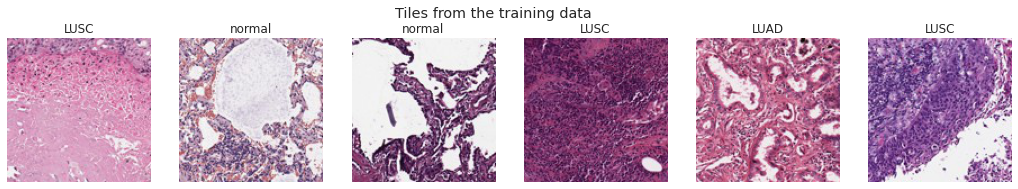

In [16]:
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'} # internal representation of classes is numeric
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Tiles from the training data')
for i, idx in enumerate([1000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

The different size and number of slides per patient results in a different number of tiles per patient. Let's check this more closely:

Total number of tiles: 18,402


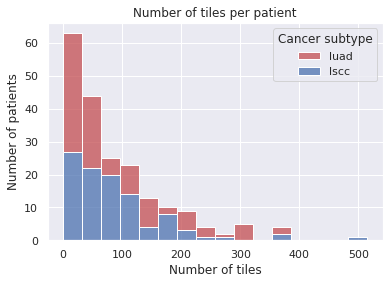

In [17]:
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Number of tiles per patient')
fig3.update({'xlabel': 'Number of tiles', 'ylabel': 'Number of patients'})
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

### Training

Following Coudray et al., we use the InceptionV3 network architecture as implemented by Keras and depicted in the figure below [[Szegedy et al., 2015]](https://arxiv.org/abs/1512.00567). The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0.

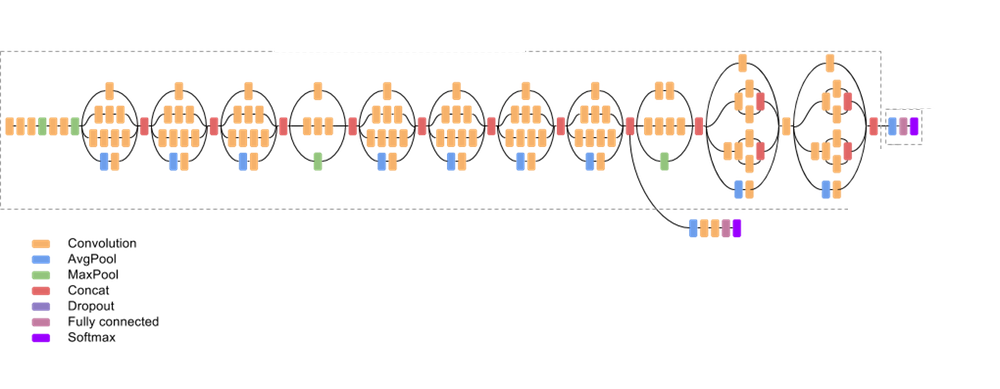

The code below performs the training process. The class [`Dataset`](./idc_pathomics/data/data_set.py) is used to load tiles from the training and validation datasets, respectively, and to compile subsets for batch-wise training. The actual training is performed by the method [`InceptionModel`](./idc_pathomics/model/inceptionv3_model.py).[`train`](./idc_pathomics/model/base_model.py). Model checkpoints are automatically stored in the `output_dir_experiment` directory after each epoch in which the validation loss improves. The training can **take up to 45 minutes** depending on the GPU used. 

In [18]:
from idc_pathomics.data.data_set import Dataset
from idc_pathomics.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

2022-04-01 15:45:46.041275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 15:45:46.192365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 15:45:46.193015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 15:45:46.194009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/10


2022-04-01 15:45:57.652952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


24/24 [==============================] - 60s 1s/step - loss: 1.6155 - auc: 0.6970 - val_loss: 18660331520.0000 - val_auc: 0.5796


2022-04-01 15:47:04.434791: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20220401_154545/checkpoint_001/assets
Epoch 2/10
24/24 [==============================] - 26s 1s/step - loss: 0.9469 - auc: 0.8451 - val_loss: 71980832.0000 - val_auc: 0.5796
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20220401_154545/checkpoint_002/assets
Epoch 3/10
24/24 [==============================] - 26s 1s/step - loss: 1.0255 - auc: 0.8646 - val_loss: 5692831.5000 - val_auc: 0.5796
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20220401_154545/checkpoint_003/assets
Epoch 4/10
24/24 [==============================] - 27s 1s/step - loss: 0.6671 - auc: 0.8878 - val_loss: 54107.0312 - val_auc: 0.5797
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20220401_154545/checkpoint_004/assets
Epoch 5/10
24/24 [==============================] - 27s 1s/step - loss: 0.6378 - auc: 0.8996 - val_loss: 844.2788 - val_auc: 0.5505
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20220401_

### Evaluation

The final model is selected as the one with the best (= minimal) loss on the validation dataset. The performance of this model is in the following evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. 

First, we make predictions for the entire test set by creating an instance of the class [`Predictions`](./idc_pathomics/evaluation/predictions.py) given our model and the test set. The predictions are then stored in CSV format in the experiment's output directory to make subsequent evaluation easily repeatable. 

In [19]:
# Load the best model (= model with minimal validation loss)
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
best_model = InceptionModel.load(best_model_dir)

In [20]:
from idc_pathomics.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc.csv'), num_classes=3)

predictions = Predictions(best_model, test_dataset, batch_size=512) 
predictions.save(os.path.join(output_dir_experiment, 'predictions.csv'))

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide are aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized below as well. Both the table and the ROC curve plots are also saved in the `output_dir_experiment` directory. In addition to the ROC curves for each class, a micro-average ROC is computed and visualized. All this functionality is implemented in the class [`ROCAnalysis`](./idc_pathomics/evaluation/roc.py). 

tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.862               0.947               0.939
LUAD            0.701               0.614               0.669
LSSC            0.899               0.886               0.864
Micro           0.756               0.775               0.797

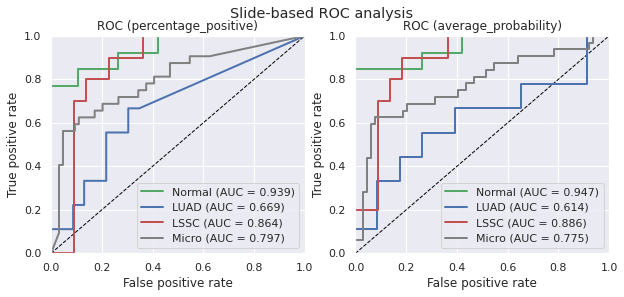

In [21]:
from idc_pathomics.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis()
roc_analysis.run(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

**Heatmaps** are generated using the method [`generate_heatmap`](./idc_pathomics/evaluation/heatmap.py) for visually inspecting the network's predictions for some slides. The slides are randomly selected from the testset using the method [`get_random_testset_slide_ids`](./idc_pathomics/data/utils.py). The color of each tile in the heatmap corresponds to the class assigned by our model. The hue indicates how confident the network is in this classification. Hereby, a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image — obtained with the method [`get_thumbnails`](./idc_pathomics/data/utils.py) — next to the heatmap. In this notebook, we limit ourselves to showing heatmaps for four random slides from the testset. 

In [22]:
from idc_pathomics.data.utils import get_random_testset_slide_ids, get_thumbnails

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
get_thumbnails(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id)

Generate thumbnail for slide C3L-04031-25


Copying gs://public-datasets-idc/c3cba7fa-a884-43b2-b535-66e4f4a26dc4.dcm...
- [1 files][ 78.1 MiB/ 78.1 MiB]                                                
Operation completed over 1 objects/78.1 MiB.                                     


Generate thumbnail for slide C3N-00579-27


Copying gs://public-datasets-idc/59342863-096c-4bd8-a03e-42fea0fc433d.dcm...
/ [1 files][ 25.7 MiB/ 25.7 MiB]                                                
Operation completed over 1 objects/25.7 MiB.                                     


Generate thumbnail for slide C3L-04878-28


Copying gs://idc-open-idc1/76e9b1dc-a190-4544-a2ba-56d7280919ef.dcm...
/ [1 files][ 18.3 MiB/ 18.3 MiB]                                                
Operation completed over 1 objects/18.3 MiB.                                     


Generate thumbnail for slide C3L-02650-25


Copying gs://idc-open-idc1/461a4695-1ecc-40aa-a654-3dd258d5cb2f.dcm...
/ [1 files][ 32.3 MiB/ 32.3 MiB]                                                
Operation completed over 1 objects/32.3 MiB.                                     


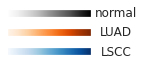

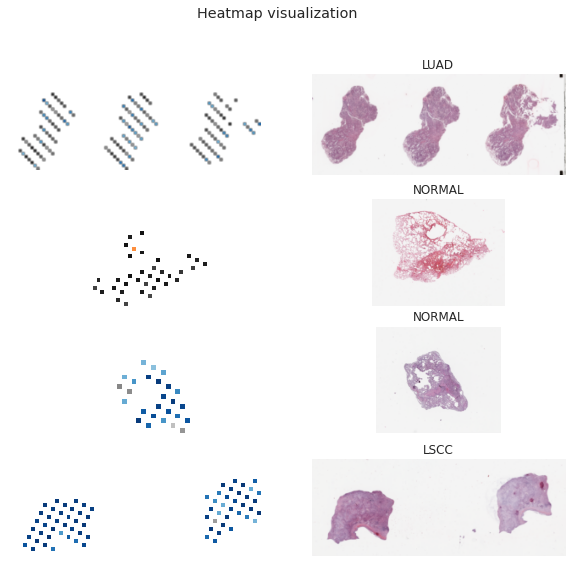

In [23]:
%%capture --no-display
from idc_pathomics.data.utils import get_slide_tissue_type
from idc_pathomics.evaluation.heatmap import generate_heatmap, plot_colormap_legend

# Generate heatmaps 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Heatmap visualization')
for i in range(4):
    slide_id = heatmap_slide_ids[i]
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    heatmap = generate_heatmap(predictions, slide_id)
    axes[i,0].imshow(heatmap)
    axes[i,1].imshow(slide)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')